In [13]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
sys.path.append(os.path.join(os.path.dirname('Demand_class'), '..', 'src'))
from Demand_class import Demand
plt.style.use('seaborn-darkgrid')

In [2]:
nat_dem = Demand()

In [3]:
path = '../data/demand_lower_48'

In [4]:
nat_dem.load_data(path)

In [5]:
df = nat_dem.dataframe

In [6]:
df.head()

,Time,Megawatthours
0,2015-07-01 02:00:00,335153
1,2015-07-01 03:00:00,333837
2,2015-07-01 04:00:00,398386
3,2015-07-01 05:00:00,388954
4,2015-07-01 06:00:00,392487


In [7]:
nat_dem.create_time_featues()

In [8]:
df = nat_dem.time_features_df
df.head()

,Time,Megawatthours,Year,Month,Hour,Day_of_week,Day_of_month,Day_of_year
0,2015-07-01 02:00:00,335153,2015,7,2,2,1,182
1,2015-07-01 03:00:00,333837,2015,7,3,2,1,182
2,2015-07-01 04:00:00,398386,2015,7,4,2,1,182
3,2015-07-01 05:00:00,388954,2015,7,5,2,1,182
4,2015-07-01 06:00:00,392487,2015,7,6,2,1,182


In [9]:
split_date = '2020-03-01 00:00:00'

In [10]:
X_train, X_test, y_train, y_test = nat_dem.scale_split(df, train_test_idx=split_date)

In [12]:
xgb_grid = {'learning_rate': [.01, .1, .2],
                'max_depth': [2, 4, 8],
                'min_samples_leaf': [2, 4], 
                'max_features': ['sqrt', 'log2'],
                'n_estimators': [500, 1000, 1500]}

In [14]:
tscv = TimeSeriesSplit(n_splits=5)

In [15]:
xgbr_gridsearch = GridSearchCV(XGBRegressor(), 
                            xgb_grid,
                            cv=tscv,
                            n_jobs=-1,
                            verbose=True,
                            scoring='neg_root_mean_squared_error')

In [16]:
xgbr_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  9.6min finished


[16:26:11] WARNING: /workspace/src/learner.cc:480: 
Parameters: { max_features, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,...
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [2, 4, 8],
                         'max_features': ['sqrt', 'lo

In [17]:
best_params = xgbr_gridsearch.best_params_

In [20]:
best_params

{'learning_rate': 0.01,
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'n_estimators': 500}

In [18]:
best_model = XGBRegressor(**best_params)

In [19]:
best_model.fit(X_train, y_train)

[16:58:38] WARNING: /workspace/src/learner.cc:480: 
Parameters: { max_features, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=8,
             max_features='sqrt', min_child_weight=1, min_samples_leaf=2,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [21]:
best_preds = best_model.predict(X_test)

In [22]:
best_preds

array([409455.5 , 394507.53, 389224.4 , ..., 389976.7 , 395893.44,
       404828.38], dtype=float32)

In [23]:
mean_absolute_error(y_test, best_preds)

22367.582387284016

In [24]:
preds_index = df['Time'].loc[df['Time'] >= split_date]
preds_index

40919   2020-03-01 00:00:00
40920   2020-03-01 01:00:00
40921   2020-03-01 02:00:00
40922   2020-03-01 03:00:00
40923   2020-03-01 04:00:00
40924   2020-03-01 05:00:00
40925   2020-03-01 06:00:00
40926   2020-03-01 07:00:00
40927   2020-03-01 08:00:00
40928   2020-03-01 09:00:00
40929   2020-03-01 10:00:00
40930   2020-03-01 11:00:00
40931   2020-03-01 12:00:00
40932   2020-03-01 13:00:00
40933   2020-03-01 14:00:00
40934   2020-03-01 15:00:00
40935   2020-03-01 16:00:00
40936   2020-03-01 17:00:00
40937   2020-03-01 18:00:00
40938   2020-03-01 19:00:00
40939   2020-03-01 20:00:00
40940   2020-03-01 21:00:00
40941   2020-03-01 22:00:00
40942   2020-03-01 23:00:00
40943   2020-03-02 00:00:00
40944   2020-03-02 01:00:00
40945   2020-03-02 02:00:00
40946   2020-03-02 03:00:00
40947   2020-03-02 04:00:00
40948   2020-03-02 05:00:00
                ...        
50149   2021-03-20 15:00:00
50150   2021-03-20 16:00:00
50151   2021-03-20 17:00:00
50152   2021-03-20 18:00:00
50153   2021-03-20 1

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


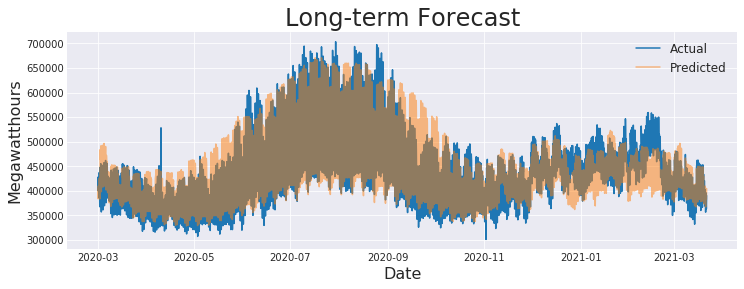

In [25]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(preds_index, y_test, label='Actual')
ax.plot(preds_index, best_preds, alpha=0.5, label='Predicted')
ax.legend(fontsize=12)
ax.set_xlabel('Date', size=16)
ax.set_ylabel('Megawatthours', size=16)
ax.set_title('Long-term Forecast', size=24)
plt.savefig('../images/xgb_best_model.png', dpi=500)
plt.show()

In [26]:
def mean_abs_percent_error(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred)/y_test)) * 100

In [27]:
mean_abs_percent_error(y_test, best_preds)

5.035539989468504